<a href="https://colab.research.google.com/github/stwind/SketchRNN_tf2/blob/master/notebooks/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# %tensorflow_version 2.x

import os
import sys
import math
import time
import numpy as np
import tensorflow as tf
from tqdm import tqdm, trange
from matplotlib import pyplot as plt
from tensorflow import keras as K

print("tf: {}".format(tf.version.VERSION))
print("tf.keras: {}".format(K.__version__))
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

tf: 2.2.0-dlenv
tf.keras: 2.3.0-tf
Num GPUs Available:  1


In [30]:
# !if cd SketchRNN_tf2; then git pull; else git clone https://github.com/stwind/SketchRNN_tf2.git; fi

sys.path.append('/content/SketchRNN_tf2')

In [31]:
# from google.colab import drive
# drive.mount('/content/gdrive')
!pwd

/home/jupyter/SketchRNN_tf2/sketchrnn


## Data

In [3]:
data_class = 'rabbit' #@param ["cat","eye","rabbit"]

# !gsutil cp gs://quickdraw_dataset/sketchrnn/{data_class}.npz .

data = np.load(f'{data_class}.npz',encoding='latin1',allow_pickle=True)

In [33]:
from os import path
path = path.join('/home/jupyter/SketchRNN_tf2', 'models')

In [34]:
!pwd

/home/jupyter/SketchRNN_tf2/sketchrnn


In [35]:
sys.path.append('/home/jupyter/SketchRNN_tf2')
from sketchrnn import models, dataset, utils


In [36]:
data['train'][0].shape

(32, 3)

In [37]:
data['train'][0]

array([[ 111,  -75,    0],
       [  35,  -15,    0],
       [  43,  -12,    0],
       [  43,    1,    0],
       [  36,   19,    0],
       [  22,   20,    0],
       [  42,   57,    1],
       [-332,    3,    0],
       [   2,    6,    0],
       [  13,   13,    0],
       [  25,   15,    0],
       [  54,   15,    0],
       [  42,    1,    0],
       [  46,   -9,    0],
       [ 107,  -10,    0],
       [  22,  -11,    0],
       [  11,  -21,    1],
       [-161,  -89,    0],
       [ -16,   11,    0],
       [ -22,   27,    0],
       [ -10,   42,    0],
       [   0,   22,    0],
       [   5,   12,    0],
       [  37,   20,    0],
       [  26,    3,    0],
       [  18,  -10,    0],
       [  17,  -24,    0],
       [   1,  -42,    0],
       [ -14,  -42,    0],
       [  -3,   -6,    0],
       [ -10,   -7,    0],
       [ -21,    0,    1]], dtype=int16)

#### apply `dataset.cleanup()` method to convert to float and remove values > 1000 or < -1000

In [6]:
import sys

sys.path.append('SketchRNN_tf2/sketchrnn')
import models
import utils
import dataset

In [7]:
data_train = [dataset.cleanup(d) for d in data['train']]
data_valid = [dataset.cleanup(d) for d in data['valid']]
data_test = [dataset.cleanup(d) for d in data['test']]

In [39]:
data_train[0]

array([[ 111.,  -75.,    0.],
       [  35.,  -15.,    0.],
       [  43.,  -12.,    0.],
       [  43.,    1.,    0.],
       [  36.,   19.,    0.],
       [  22.,   20.,    0.],
       [  42.,   57.,    1.],
       [-332.,    3.,    0.],
       [   2.,    6.,    0.],
       [  13.,   13.,    0.],
       [  25.,   15.,    0.],
       [  54.,   15.,    0.],
       [  42.,    1.,    0.],
       [  46.,   -9.,    0.],
       [ 107.,  -10.,    0.],
       [  22.,  -11.,    0.],
       [  11.,  -21.,    1.],
       [-161.,  -89.,    0.],
       [ -16.,   11.,    0.],
       [ -22.,   27.,    0.],
       [ -10.,   42.,    0.],
       [   0.,   22.,    0.],
       [   5.,   12.,    0.],
       [  37.,   20.,    0.],
       [  26.,    3.,    0.],
       [  18.,  -10.,    0.],
       [  17.,  -24.,    0.],
       [   1.,  -42.,    0.],
       [ -14.,  -42.,    0.],
       [  -3.,   -6.,    0.],
       [ -10.,   -7.,    0.],
       [ -21.,    0.,    1.]], dtype=float32)

In [40]:
# Generate random 40 indexes in data_train
perm = np.random.permutation(range(len(data_train)))[:40]
perm

array([39912,  3591, 11345,  7602, 52135, 68440, 17741, 42861, 62491,
       53513, 16121, 11107, 52665, 51864, 29481,  6315,   679, 12099,
       41536,  9237,  5217, 48179, 43153, 67336, 30607, 14541, 45474,
       64012, 24926, 58186, 22875, 29715,  4808, 46219, 42677, 41629,
       52519, 66412, 24196, 23110])

#### Use `utils.plot_strokes(ax, strokes, ec="black", no_ticks=True)` method to plot

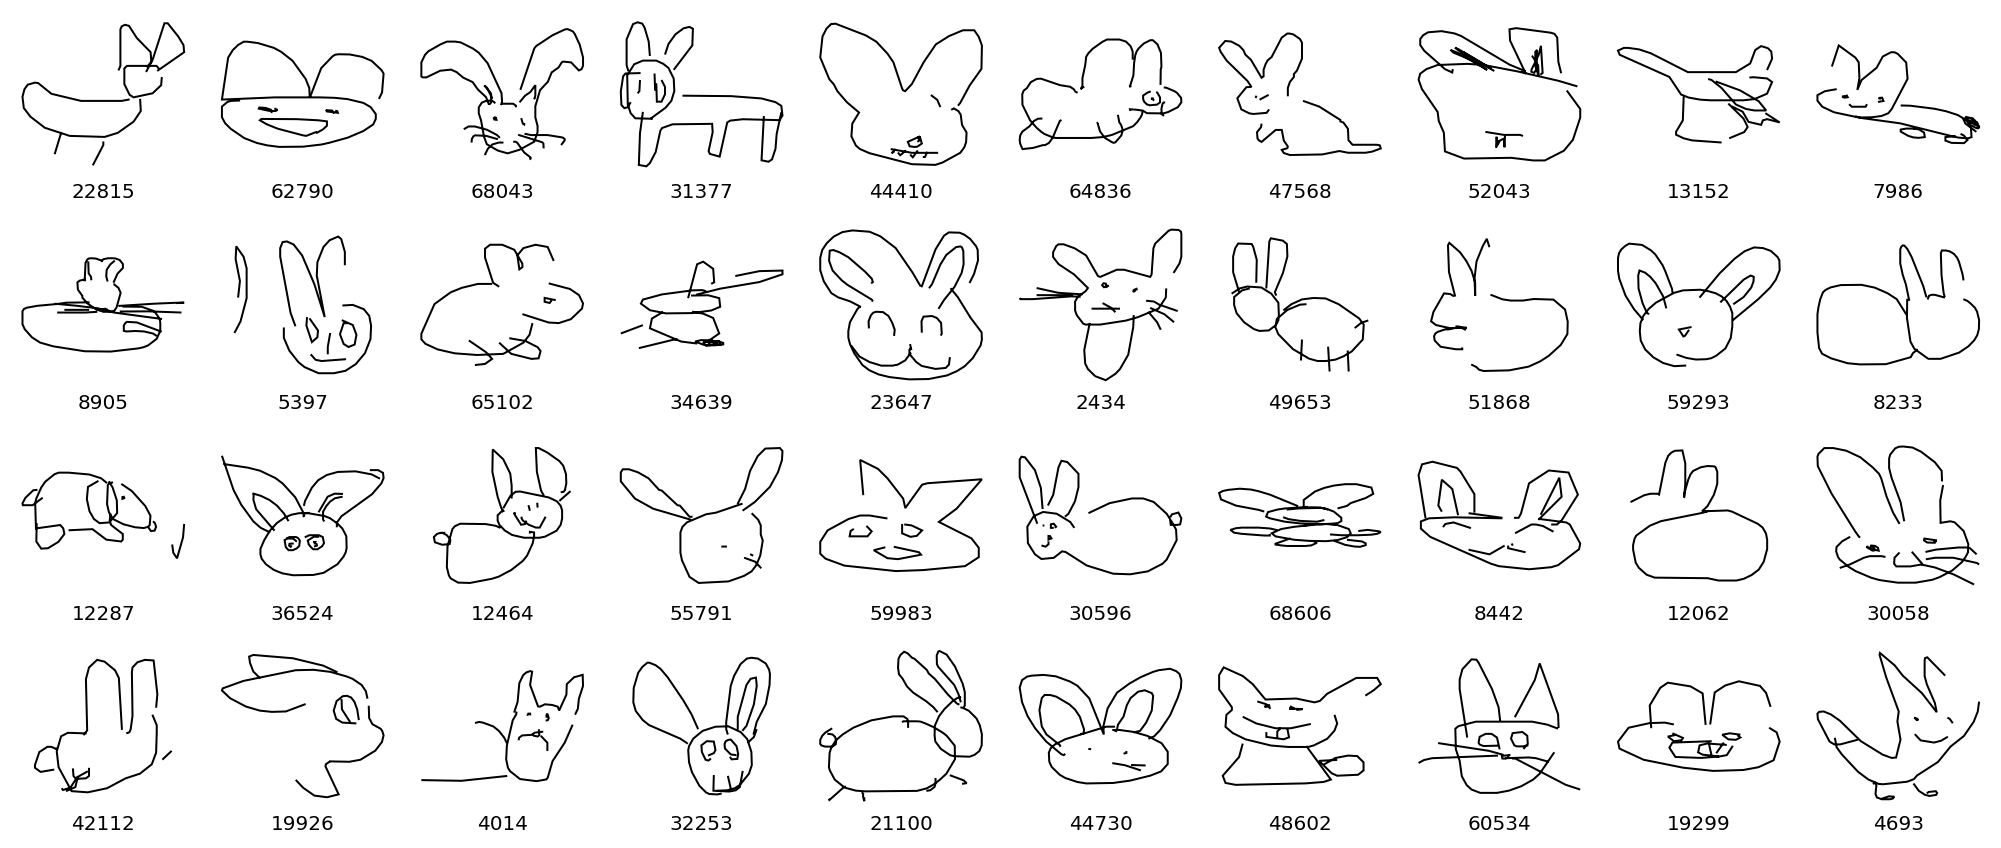

In [8]:
n = [4, 10]

fig, ax = plt.subplots(n[0],n[1],figsize=(14, 6))
# print("ax", ax)

perm = np.random.permutation(range(len(data_train)))[:n[0]*n[1]]

for i, idx in enumerate(perm):
    x, y = i // n[1], i % n[1]
#     print("x, y: ", x, y)
    utils.plot_strokes(ax[x][y], data_train[idx])
    ax[x][y].set(xlabel=idx)
    
utils.plt_show()

#### `utils.make_mpl_path(strokes)` returns a Path object which specifies the vertices and codes so `utils.plot_strokes()` can plot them

In [42]:
utils.make_mpl_path(data_train[0])

Path(array([[ 0.33132523,  0.28915662],
       [ 0.12048185,  0.37951809],
       [-0.13855433,  0.45180723],
       [-0.3975904 ,  0.44578314],
       [-0.61445785,  0.33132532],
       [-0.74698806,  0.21084338],
       [-1.        , -0.13253012],
       [ 0.99999988, -0.15060242],
       [ 0.9879517 , -0.186747  ],
       [ 0.9096384 , -0.26506025],
       [ 0.75903606, -0.35542169],
       [ 0.43373483, -0.44578314],
       [ 0.18072283, -0.45180723],
       [-0.0963856 , -0.3975904 ],
       [-0.74096394, -0.33734941],
       [-0.87349403, -0.27108434],
       [-0.93975914, -0.14457832],
       [ 0.03012037,  0.39156628],
       [ 0.12650591,  0.32530123],
       [ 0.25903606,  0.16265061],
       [ 0.31927699, -0.09036145],
       [ 0.31927699, -0.22289157],
       [ 0.28915656, -0.29518074],
       [ 0.06626499, -0.41566265],
       [-0.09036148, -0.43373495],
       [-0.1987952 , -0.373494  ],
       [-0.30120492, -0.22891566],
       [-0.30722904,  0.02409639],
       [-0.2228

## Models

#### `max_seq_len` is to find the sketch with the longest strokes. Each sketch have different strokes length

In [43]:
len(data_train[2])

55

In [44]:
max(map(len, np.concatenate([data['train'], data['valid'], data['test']])))

125

In [9]:
# Specify the hyperparameters

hps = {
    "max_seq_len": max(map(len, np.concatenate([data['train'], data['valid'], data['test']]))),
    'batch_size': 100,
    "num_batches": math.ceil(len(data_train) / 100),
    "epochs": 100,
    "recurrent_dropout_prob": 0.1, ## 0.0 for gpu lstm
    "enc_rnn_size": 256,
    "dec_rnn_size": 512,
    "z_size": 128,
    "num_mixture": 20,
    "learning_rate": 0.001,
    "min_learning_rate": 0.00001,
    "decay_rate": 0.9999,
    "grad_clip": 1.0,
    'kl_tolerance': 0.2,
    'kl_decay_rate': 0.99995,
    "kl_weight": 0.5,
    'kl_weight_start': 0.01,
}

#### `models.SketchRNN(hps)` will construct a sketchrnn model
- Encoder: 
    - Input Layer: shape=(131,5) as max_seq_len=131
    - Encoder LSTM Cell: with enc_rnn_size=256 and recurrent_dropout_prob=0.1
    - Encoder Output: A Bidirectional RNN layer that takes in Input Layer
    - mu = Dense Layer taking in Encoder Output
    - sigma = Dense Layer taking in Encoder Output
    - Latent_z = Lambda Layer that applies `reparameterize()` to mu and sigma
    - Overall: Model(inputs=encoder_input, outputs=[latent_z, mu, sigma], name="encoder")
- Initial_state:
    - z_input: Input Layer(shape=(z_size=128,), name="z_input")
    - initial_state = Dense Layer(units=dec_rnn_size * 2, activation="tanh", kernel_initializer=K.initializers.RandomNormal(mean=0.0, stddev=0.001)) that takes in z_input
    - states = tf.split(initial_state, 2, 1) where tf.split(X, row = n, column = m) is used to split the data set of the variable into n number of pieces row wise and m numbers of pieces column wise
    - Overall: Model(inputs=z_input, outputs=states, name="initial_state")
- Decoder:
    - Input Layer: shape(None, 5)
    - z_input: Input(shape=(z_size=128,))
    - initial_h_input = Input Layer(shape=(dec_rnn_size=512,), name="init_h")
    - initial_c_input = Input Layer(shape=(dec_rnn_size=512,), name="init_c")
    - Decoder LSTM = LSTM Layer(units=dec_rnn_size=512, recurrent_dropout=recurrent_dropout_prob=0.1)
    - tile_z = tf.tile(tf.expand_dims(z_input, 1), [1, tf.shape(decoder_input)[1], 1]) where tf.tile() new tensor by replicating input multiples times. The output tensor's i'th dimension has input.dims(i) * multiples[i] elements
    - decoder_full_input = tf.concat([decoder_input, tile_z], -1)
    - decoder_output, cell_h, cell_c = Decoder LSTM(decoder_full_input, initial_state=[initial_h_input, initial_c_input])
    - output_layer = Dense Layer(units=num_mixture=20 * 6 + 3, name="output")
    - output = output_layer(decoder_output)
    - Overall: Model(inputs=[decoder_input, z_input, initial_h_input, initial_c_input],
                     outputs=[output, cell_h, cell_c],  name="decoder",)
- Model Builder:
    - Encoder produces latent vector: z_out, mu value: mu_out, sigma value: sigma_out
    - Initializer use latent vector to produce init_h, init_c
    - Decoder produces some output, cell_h, cell_c
    - Overall, model takes in [encoder_input, decoder_input] and produces [output, mu_out, sigma_out]

In [10]:
sketchrnn = models.SketchRNN(hps)
sketchrnn.models['full'].summary()

Model: "sketchrnn"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      [(None, 131, 5)]     0                                            
__________________________________________________________________________________________________
encoder (Model)                 [(None, 128), (None, 667904      encoder_input[0][0]              
__________________________________________________________________________________________________
decoder_input (InputLayer)      [(None, None, 5)]    0                                            
__________________________________________________________________________________________________
initial_state (Model)           [(None, 512), (None, 132096      encoder[1][0]                    
__________________________________________________________________________________________

## Training

In [11]:
scale_factor = dataset.calc_scale_factor(data_train)

train_dataset = dataset.make_train_dataset(data_train, hps['max_seq_len'], hps['batch_size'], scale_factor)
val_dataset = dataset.make_val_dataset(data_valid, hps['max_seq_len'], hps['batch_size'], scale_factor)

In [48]:
!pwd

/home/jupyter/SketchRNN_tf2/sketchrnn


In [ ]:
checkpoint_dir = 'SketchRNN_tf2/sketchrnn/SketchRNN_tf2/checkpoints'
log_dir = 'SketchRNN_tf2/sketchrnn/SketchRNN_tf2/logs'

!mkdir -p "{log_dir}" "{checkpoint_dir}"

initial_epoch = 90 #@param {type: "number"}
initial_loss = 0.05 #@param {type: "number"}
checkpoint = os.path.join(checkpoint_dir, 'sketch_rnn_' + data_class + '_weights.{:02d}_{:.2f}.hdf5')

# if initial_epoch > 0:
#     sketchrnn.load_weights(checkpoint.format(initial_epoch, initial_loss))

In [ ]:
sketchrnn.train(initial_epoch, train_dataset, val_dataset, checkpoint)

In [ ]:
# sketchrnn.save("sketch_rnn_rabbit_weights.90_0.05")